In [33]:
%reset -f

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import Helpers

#import cleaned_data.csv to pandas.

data = pd.read_csv('cleaned_data.csv')

X_train, X_test, y_train, y_test = Helpers.split_data(data)

gradient_monitor = Helpers.GradientMonitor()


In [34]:
data

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Geography,Gender
0,581,34.0,148882.54,1,1.0,84560.88,France,Male
1,588,36.0,131778.58,1,1.0,136024.31,Germany,Male
2,593,30.0,144772.69,1,1.0,29792.11,France,Female
3,678,37.0,138476.41,1,1.0,106851.60,Spain,Male
4,583,40.0,81274.33,1,1.0,170843.07,Germany,Male
...,...,...,...,...,...,...,...,...
125519,752,32.0,160729.10,1,1.0,142223.94,Spain,Male
125520,667,43.0,83765.35,1,1.0,118358.54,Germany,Female
125521,570,29.0,116099.82,1,1.0,148087.62,Spain,Male
125522,575,36.0,178032.53,1,1.0,42181.68,France,Female


In [35]:
# Define the features that need encoding and those that don't
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Balance', 'NumOfProducts','HasCrCard']


In [36]:
# Create transformers for the pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Adding RobustScaler for numerical features
numerical_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

def create_model(input_dim, learning_rate):
    model = Sequential()
    model.add(Dense(1024, input_shape=(input_dim,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Using linear output for regression
    # Configure the model with the Adam optimizer and a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model



In [37]:
# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Define Keras model in the pipeline
model = KerasRegressor(build_fn=lambda: create_model(input_dim=preprocessor.transform(X_train).shape[1], learning_rate=0.0005),
                       epochs=5000, batch_size=512, verbose=1)

# Wrap the Keras model with target transformation
target_scaler = StandardScaler()
tt_reg = TransformedTargetRegressor(regressor=model, transformer=target_scaler)





In [38]:
# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', tt_reg)
])

reduce_lr = ReduceLROnPlateau(patience=10)

callbacks = [gradient_monitor, reduce_lr]

# Apply the pipeline to the data
pipeline.fit(X_train, y_train, regressor__callbacks=callbacks)


Epoch 1/5000


E:\DataSpellProjects\SKFSkraper\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
E:\DataSpellProjects\SKFSkraper\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 1.0217
Epoch 2/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.9992
Epoch 3/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.9979
Epoch 4/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.9967
Epoch 5/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.9950
Epoch 6/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.9960
Epoch 7/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.9986
Epoch 8/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.9980
Epoch 9/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.9905
Epoch 10/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.9997
Epoch 11/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 1.0025
Epoch 12/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.9950
Epoch 13/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.9975
Epoch 14/5000
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 1.0004
Epoch 15/5000


KeyboardInterrupt: 

In [79]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Mean Squared Error: 2508195150.843782


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


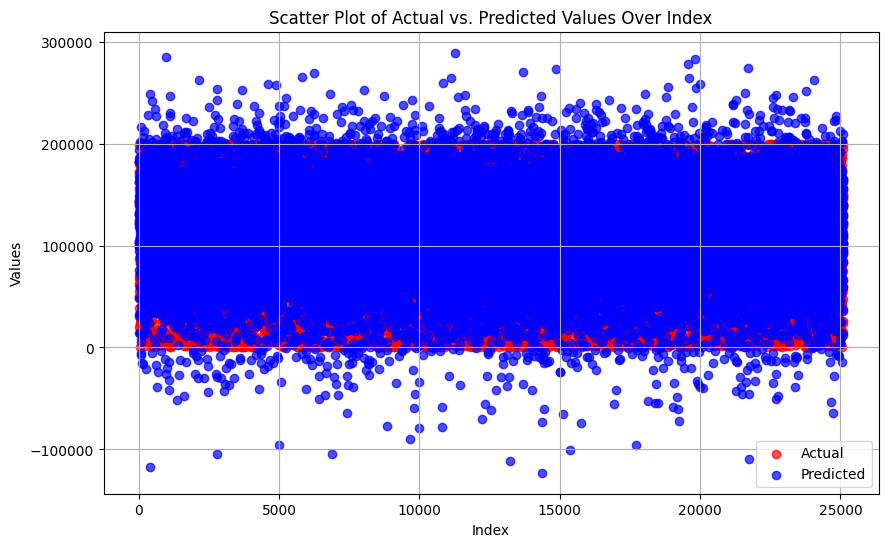

In [7]:
import matplotlib.pyplot as plt

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Create indices for x-axis
index = range(len(y_test))

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(index, y_test, color='red', label='Actual', alpha=0.7)
plt.scatter(index, y_pred, color='blue', label='Predicted', alpha=0.7)

plt.title('Scatter Plot of Actual vs. Predicted Values Over Index')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
y_test

51511     121276.25
94442     180800.42
114153     38867.46
109245     48553.77
73047     142987.11
            ...    
64923     162501.83
124193     15650.89
99030      24208.84
59404      38153.19
84180      26257.01
Name: EstimatedSalary, Length: 25105, dtype: float64